In [ ]:
from zipfile import ZipFile
import os.path
from os import path
from google.colab import drive

import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import pandas as pd

import numpy as np
import pandas as pd
import os
from collections import defaultdict
from tqdm import tqdm
import shutil

import os
import shutil
from random import shuffle

import matplotlib.pyplot as plt
from PIL import Image

import cv2
import random

In [ ]:
!pip install pybboxes

In [ ]:
import pybboxes as pbx

In [ ]:
# Dataset


## 1. Settings

### 1.1 Pathes

In [ ]:
# 1. Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 2. pathes
path_main_dir = '/content/drive/MyDrive/study/DL2/traffic_signs'
data_file = r'driver_signes.zip'
unzip_dir = r'driver_signes'
images_path = f"{path_main_dir }/{unzip_dir}/images"

# Change directory
os.chdir(path_main_dir)

# Print out the current directory
!pwd

/content/drive/MyDrive/study/DL2/traffic_signs


In [ ]:
# 3 model name
model_name = 'yolov5'
model_path = f"{path_main_dir }/{model_name}"

### 1.2 Clone Yolov5 model

In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [ ]:
# install need libries for yolov5
%cd ./yolov5
!pip install -r requirements.txt

/content/drive/MyDrive/study/DL2/traffic_signs/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.9/605.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


### 1.3 Generate annotations in yolo format

In [ ]:
!pwd

In [ ]:
%cd ..

In [ ]:
# 1. extract zipfile - fun
def zip_reader(in_path, out_path):
    """ This function will extract zipfile """

    with ZipFile(in_path, mode = 'r') as f:
        print('Extracting Data...')
        f.extractall(out_path)   # Extract zip file.
        print('Extraction Completed.')

In [ ]:
# 2. extract zipfile
input_path = path_main_dir+'/'+data_file
output_path = path_main_dir+'/'+unzip_dir

zip_reader(in_path = input_path, out_path = output_path)

Extracting Data...
Extraction Completed.


In [ ]:
# 3. path to annotation
annotations_path = os.path.join(output_path, 'annotations')
annotations = os.listdir(annotations_path)
print(annotations_path)

/content/drive/MyDrive/study/DL2/traffic_signs/driver_signes/annotations


In [ ]:
# 4. collect data from xml
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append(img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)

100%|██████████| 877/877 [00:01<00:00, 677.18it/s]


In [ ]:
# 5. save annotation data at need format
labels_df = pd.DataFrame({
                        'img_name': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'label': label_list})
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label
0,road0.png,267,400,98,62,208,232,trafficlight
1,road1.png,400,283,154,63,258,281,trafficlight
2,road10.png,400,267,106,3,244,263,trafficlight
3,road100.png,400,385,35,5,363,326,speedlimit
4,road101.png,400,200,195,7,392,194,speedlimit


In [ ]:
# 6. Determine labels
classes = labels_df['label'].unique().tolist()
labels_df['class'] = labels_df['label'].apply(lambda x: classes.index(x))
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label,class
0,road0.png,267,400,98,62,208,232,trafficlight,0
1,road1.png,400,283,154,63,258,281,trafficlight,0
2,road10.png,400,267,106,3,244,263,trafficlight,0
3,road100.png,400,385,35,5,363,326,speedlimit,1
4,road101.png,400,200,195,7,392,194,speedlimit,1


In [ ]:
# 7. Generate dictionary where key is image_name and value is list of all bboxes inforamtion
img_dict = defaultdict(list)

for idx in tqdm(range(len(labels_df))):
    sample_label_list = []
    img_name = labels_df.loc[idx, 'img_name']
    xmin = labels_df.loc[idx, 'xmin']
    ymin = labels_df.loc[idx, 'ymin']
    xmax = labels_df.loc[idx, 'xmax']
    ymax = labels_df.loc[idx, 'ymax']
    class_num = labels_df.loc[idx, 'class']
    W, H = int(labels_df.loc[idx, 'width']), int(labels_df.loc[idx, 'height'])

    voc_bbox = (int(xmin), int(ymin) ,int(xmax), int(ymax))

    x_center, y_center, w, h = pbx.convert_bbox(voc_bbox, from_type="voc", to_type="yolo", image_size=(W,H))

    sample_label_list.append(str(class_num))
    sample_label_list.append(str(x_center))
    sample_label_list.append(str(y_center))
    sample_label_list.append(str(w))
    sample_label_list.append(str(h))
    line = ' '.join(sample_label_list)

    img_dict[img_name].append(line)

# example
print()
print(img_dict['road100.png'])


['1 0.4975 0.42987012987012985 0.82 0.8337662337662337']


In [ ]:
# 8. make labels dir in data folder of yolov5
labels_dir = f'{path_main_dir}/yolov5/data/labels'
if os.path.exists(labels_dir):
    shutil.rmtree(labels_dir)
os.mkdir(labels_dir)

In [ ]:
## Generate .txt file for each image
for img_name, lines in img_dict.items():
    img_name = img_name.split('.')[0]
    with open(f'{labels_dir}/{img_name}.txt', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

### 1.4 Train test split

In [ ]:
# 1. create train , val folders in data directory of yolov5
labels_path = labels_dir   ## directory having labels in .txt format

train_dir = model_path + '/data/train'
val_dir = model_path + '/data/val'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.mkdir(train_dir)
os.mkdir(val_dir)

# 2. train, val each containing images and labels folders
os.mkdir(train_dir + '/images')
os.mkdir(train_dir + '/labels')
os.mkdir(val_dir + '/images')
os.mkdir(val_dir + '/labels')

In [ ]:
# 3. Shuffle image file names before splitting into train and val data
files = os.listdir(images_path)
shuffle(files)

In [ ]:
# split and copy files in destinations
def split(files, ratio):
    elements = len(files)
    middle = int(elements * ratio)
    return [files[:middle], files[middle:]]

def copy_files(images_path, labels_path, destination_path, files):

    for file_name in files:
        file_name = file_name.split('.')[0]

        src = images_path + f'/{file_name}.png'
        dst = destination_path + '/images'
        shutil.copy(src, dst)

        src = labels_path + f'/{file_name}.txt'
        dst = destination_path + '/labels'
        shutil.copy(src, dst)

In [ ]:
# 4. Split and copy files in train and val folder
train_ratio = 0.75
train_files, val_files = split(files, train_ratio)

# root = 'data/traffic_sign_data'
# 5. copy files
copy_files(images_path, labels_path, train_dir, train_files)
copy_files(images_path, labels_path, val_dir, val_files)

In [ ]:
# Check that everything is ok
assert (len(os.listdir(train_dir + '/images')) + len(os.listdir(val_dir + '/images')) == len(os.listdir(images_path)))

### 1.5 Generate .yaml file

In [ ]:
with open(f'{model_path}/data/sign_data.yaml', 'w') as f:
    f.write('train: ../data/train/images\n')
    f.write('val: ../data/val/images\n')
    f.write('nc: 4\n')
    f.write(f"names: {classes}")

## 2. Train model

In [ ]:
# 1. get to yolov5
%cd ./yolov5

In [ ]:
# 2. Train param
epochs = 50
!python train.py --img 640 --batch 16 --epochs {epochs} --data sign_data.yaml --weights yolov5s.pt

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

train: weights=yolov5s.pt, cfg=, data=sign_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=

## 3. Visualize validation results

In [ ]:
!pwd

/content/drive/MyDrive/study/DL2/traffic_signs/yolov5


#### 3.1 Table with model result

In [ ]:
# 1. Add path from results
exp = sorted(os.listdir(model_path + '/runs/train'))[-1]
exp_path = model_path + '/runs/train/' + exp

In [ ]:
# 2. Download result table
res = pd.read_csv(f"{exp_path}/results.csv")
res.columns = res.columns.str.strip()

# 3. Find the best model
res2 = res.iloc[res['metrics/mAP_0.5'].idxmax()]

# 4. save result
res_tab = pd.DataFrame({'model': model_name,
#  'precision': res2['metrics/precision'],
#  'recall': res2['metrics/recall'],
 'mAP_0.5': res2['metrics/mAP_0.5'],
 'mAP_0.5:0.95': res2['metrics/mAP_0.5:0.95'],
}, index = [0])

res_tab

,model,precision,recall,mAP_0.5,mAP_0.5:0.95
0,yolov5,0.94298,0.91794,0.94369,0.76333


#### 3.2 Precision recall

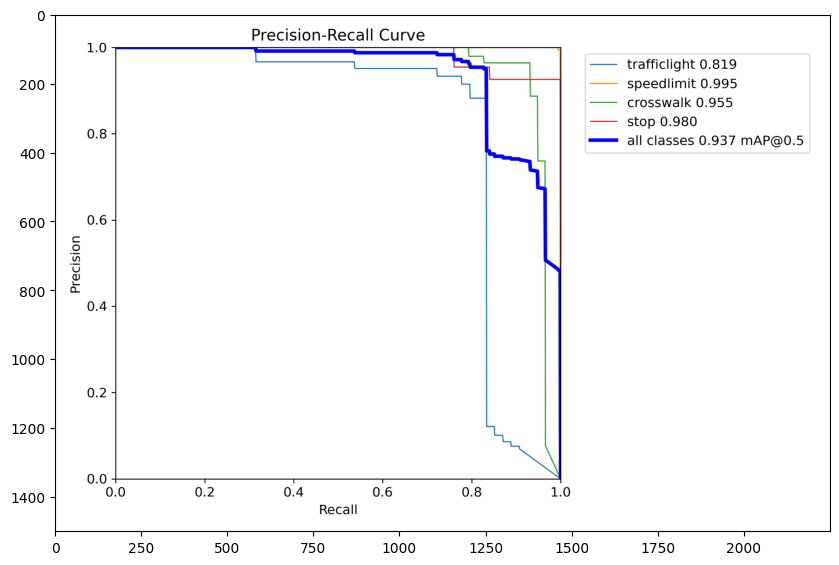

In [ ]:
pr_path = exp_path+'/PR_curve.png'
img = Image.open(pr_path)
plt.figure(figsize=(10, 10))
plt.imshow(img);

#### 3.3 Confusion matrix

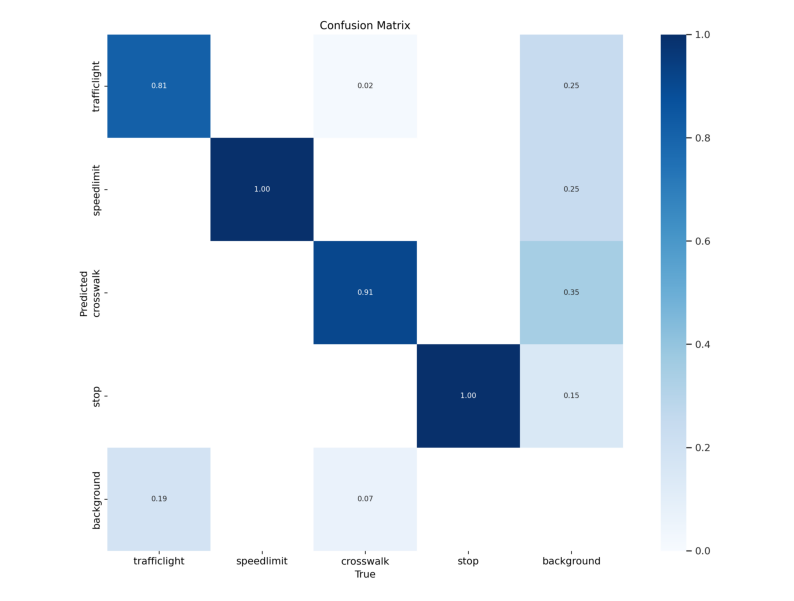

In [ ]:
cm_path = exp_path+'/confusion_matrix.png'
img = Image.open(cm_path)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(img);

#### 3.4 Batch visualisation

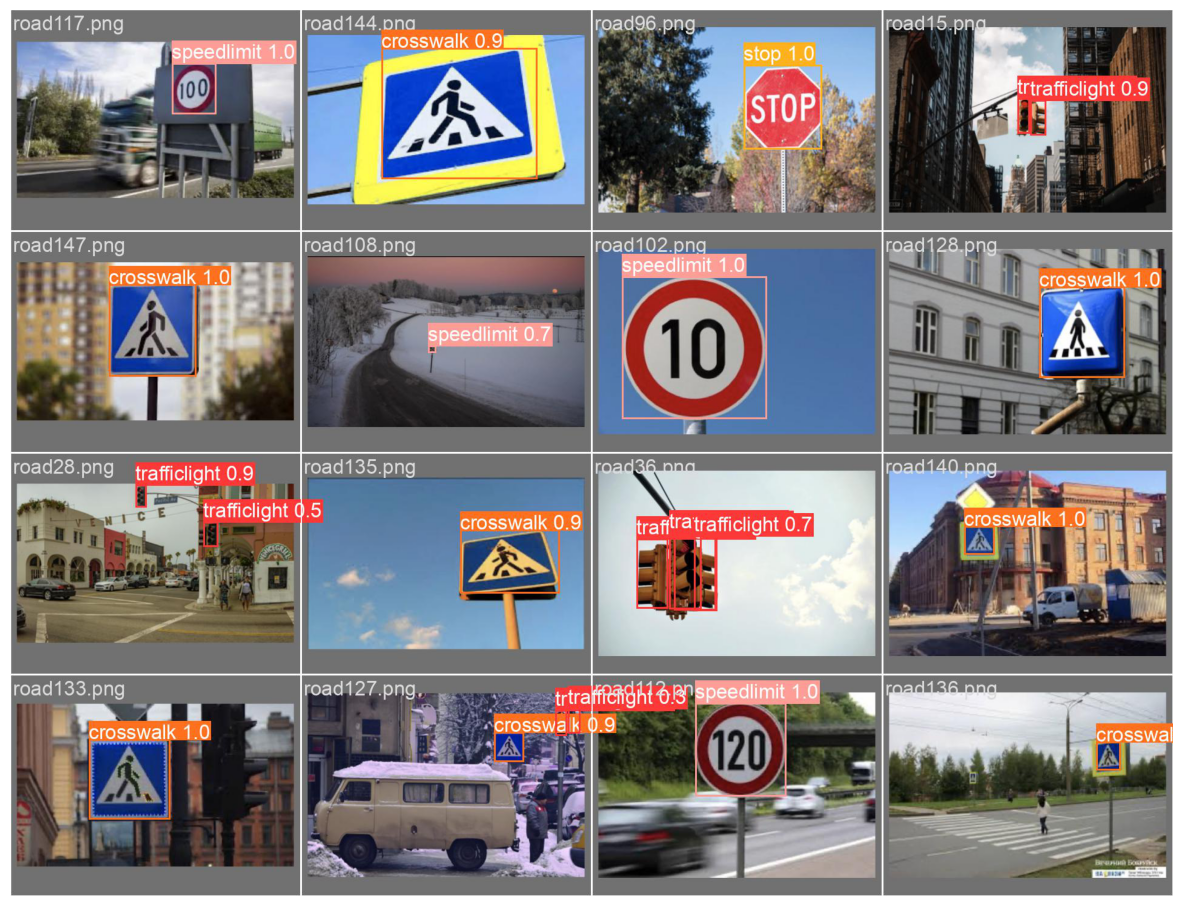

In [ ]:
# 2. Butch visualization
img_path = exp_path + '/val_batch0_pred.jpg'
img = Image.open(img_path)
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(img);

## 4. Prediction

#### 4.1 Photos

In [ ]:
# 1.Make prediction - photo
!python detect.py --weights /content/drive/MyDrive/study/DL2/traffic_signs/yolov5/runs/train/exp3/weights/best.pt --img 640 --conf 0.4 --iou-thres 0.45 --source /content/drive/MyDrive/study/DL2/traffic_signs/yolov5/data/val/images --save-txt --save-conf

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

detect: weights=['/content/drive/MyDrive/study/DL2/traffic_signs/yolov5/runs/train/exp3/weights/best.pt'], source=/content/drive/MyDrive/study/DL2/traffic_signs/yolov5/data/val/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, 

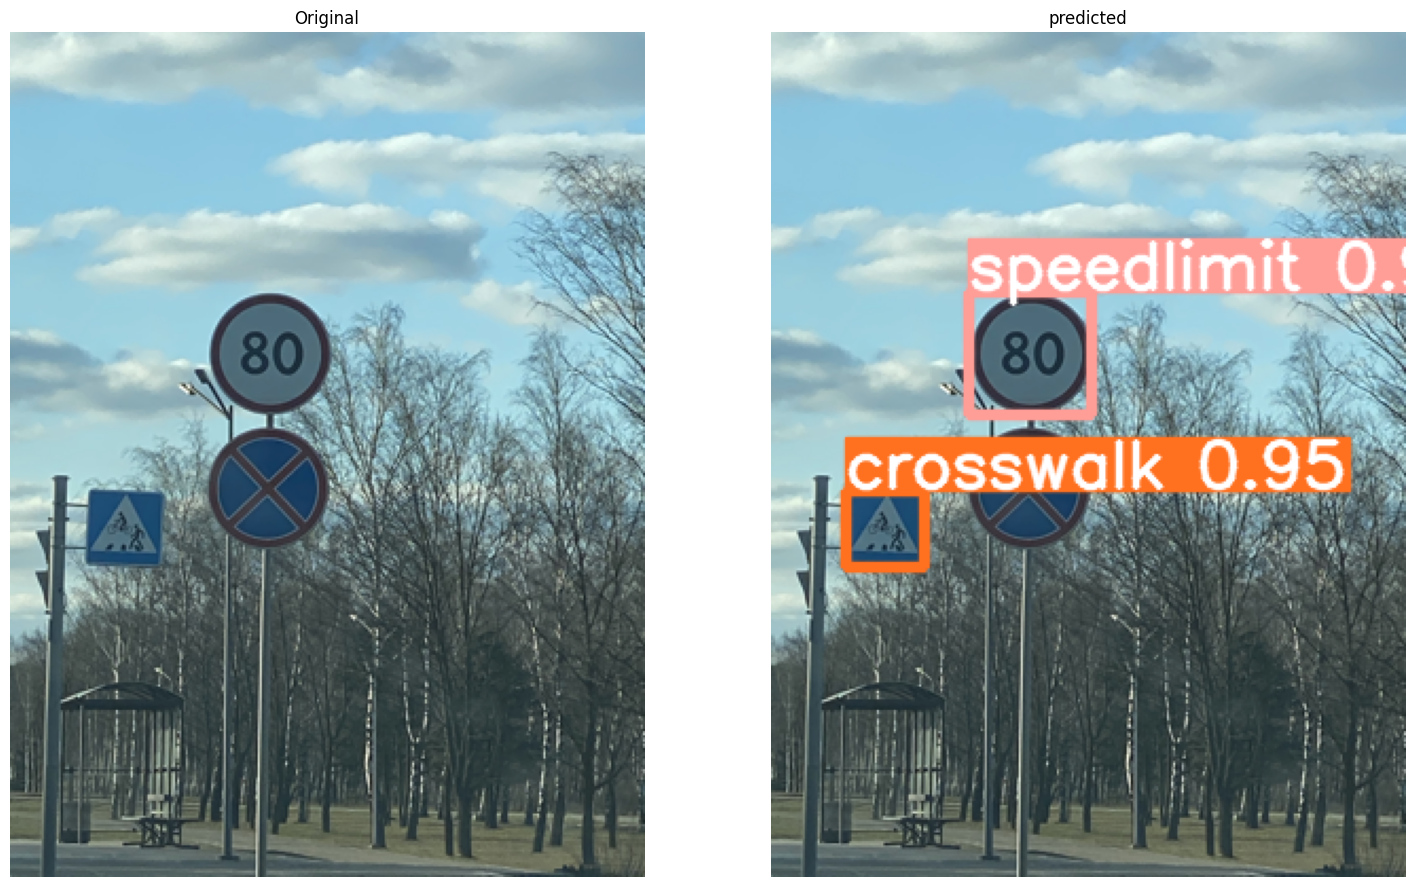

In [ ]:
# 2. Visualisation
# 2.1 Select predicted_files
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk(f"{model_path}/runs/detect/exp7"):
    predicted_files.extend([f for f in filenames if f.endswith('.png')])


# 2.2 Select random one
index=random.choice(predicted_files)
dirpath=f"{model_path}/runs/detect/exp7"
detected_path= dirpath +"/"+ str(index)
detected_img=cv2.imread(detected_path)
detected_img=cv2.cvtColor(detected_img,cv2.COLOR_BGR2RGB)

# 2.3 Seelct original photo
path=f"{model_path}/data/val/images"
original_path= path + "/" + str(index)
img=cv2.imread(original_path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

#plotting:
plt.figure(figsize=(18,12))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(detected_img)
plt.title("predicted")
plt.axis("off");

#### 4.2 Video

In [ ]:
!pwd

/content/drive/MyDrive/study/DL2/traffic_signs/yolov5


In [ ]:
%cd ./yolov5

/content/drive/MyDrive/study/DL2/traffic_signs/yolov5


In [ ]:
!python detect.py --weights /content/drive/MyDrive/study/DL2/traffic_signs/yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.30 --iou-thres 0.45 --source /content/drive/MyDrive/study/DL2/traffic_signs/video/video_v3.mp4 --save-txt --save-conf

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

detect: weights=['/content/drive/MyDrive/study/DL2/traffic_signs/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/study/DL2/traffic_signs/video/video_v3.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist

In [ ]:
# 1. Add to app